In [1]:
import numpy as np
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

# NumPy Feed-Forward Neural Network

This notebook walks through the process of constructing a feed-forward neural network for multi-class classification solely using NumPy.

## Layers

For our neural network, we want to abstract away from individual neurons and focus on layers. Each element of the network will be defined by a certain layer.

### Base Layer

The abstract base layer ensures that all called methods by the `Sequential` model exist on the layers. 

In [2]:
class Layer:
    """Base class for neural network layers."""

In this case, we only need to worry about the `sgd_step` method as some layers won't need to update any weights because they don't have any (e.g. activation layers).

In [3]:
    def sgd_step(self, lrate):
        """Some layers do not have weights to update on gradient descent steps."""

# Add this method to the Layer class
Layer.sgd_step = sgd_step

### Linear Layer

This is the simplest layer that makes up the majority of our neural network.

In [4]:
class Linear(Layer):
    """A simple, fully-connected linear layer."""

To set up this layer, we need to know the input and output dimensions ahead of time. Using this information, we randomly initialize the weight matrices.

In [5]:
    def __init__(self, m, n):
        """Initializes the layer based on input and output dimensions. 

        Note: Kernel is initialized using normal distribution with mean 0 and 
        variance 1 / m. All biases are initialized to zero.

        Args:
            m (int): Number of inputs to the layer.
            n (int): Number of outputs from the layer.

        """
        self.m, self.n = m, n

        self.W0 = np.zeros((n, 1))
        self.W = np.random.normal(0, np.sqrt(1 / m), (m, n))

# Add this method to the Linear layer class
Linear.__init__ = __init__

The `forward` method will compute the output of the layer given a set of $m$ inputs from the previous layer for a batch of size $b$.

In [6]:
    def forward(self, A):
        """Computes the forward pass through the linear network for a batch.

        Args:
            A (ndarray): An m by b matrix representing the m activations from the
                previous layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the result of passing the 
                activations through the network layer for a batch of size b.

        """
        self.A = A

        return self.W.T @ self.A + self.W0

# Add this method to the Linear layer class
Linear.forward = forward

The `backward` method will compute the gradient of the loss with respect to the inputs to the layer for a batch of size $b$. Note: There is an implicit sum over all $b$ in the `dLdW` calculation.

In [7]:
    def backward(self, dLdZ):
        """Uses the gradient of loss with respect to outputs of the layer for a 
        batch to update the sum of gradients of the loss with respect to the 
        weights for the entire batch. Also returns the gradient of the loss with 
        respect to the inputs to the layer for a batch.

        Args:
            dLdZ (ndarray): An n by b matrix representing the gradient of the loss
                with respect to the layer outputs for a batch of size b.

        Returns:
            ndarray: An m by b matrix representing the gradient of the loss with 
                respect to the inputs to the layer for a batch of size b.

        """
        self.dLdW = self.A @ dLdZ.T  # Implicit sum over all b
        self.dLdW0 = np.sum(dLdZ, axis=1, keepdims=True)

        return self.W @ dLdZ

# Add this method to the Linear layer class
Linear.backward = backward

Lastly, we need a method to update the weight matrices using the current weight gradients for a batch.

In [8]:
    def sgd_step(self, lrate):
        """Performs a single step of gradient descent to update the weights for a 
        single batch of points.

        Args:
            lrate (float): A learning rate to scale the gradient for the update.

        """
        self.W = self.W - lrate * self.dLdW
        self.W0 = self.W0 - lrate * self.dLdW0
        
# Add this method to the Linear layer class
Linear.sgd_step = sgd_step

### Hyperbolic Tangent Activation Layer

This layer encapsulates the hyperbolic tangent activation function.

In [9]:
class Tanh(Layer):
    """Hyperbolic tangent activation layer."""

The `forward` method take a preactivation from the previous layer and computes the activation using the hyperbolic tangent function.

In [10]:
    def forward(self, Z):
        """Computes the output of the hyperbolic tangent activation layer.

        Args:
            Z (ndarray): An n by b matrix representing the input pre-activations
                of the layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the output of the layer after
                using the hyperbolic tangent activation on all inputs for a batch
                of size b.

        """
        self.A = np.tanh(Z)

        return self.A

# Add this method to the Tanh layer class
Tanh.forward = forward

The `backward` method computes the gradient of the loss with respect to the inputs to the activation layer.

In [11]:
    def backward(self, dLdA):
        """Computes the gradient of the loss with respect to the inputs to the
        layer using the gradient of the loss with respect to the outputs of the
        layer for a single batch.

        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of the loss
                with respect to the outputs for the layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the gradient of the loss with
                respect to the inputs of the layer for a batch of size b.

        """
        return (1 - self.A ** 2) * dLdA

# Add this method to the Tanh layer class
Tanh.backward = backward

This layer has no weights to update. Therefore, no `sgd_step` function is required.

### Rectified Linear Unit Activation Layer

This layer encapsulates the rectified linear unit activation function.

In [12]:
class ReLU(Layer):
    """Rectified linear unit layer."""

The `forward` method take a preactivation from the previous layer and computes the activation using the relu function.

In [13]:
    def forward(self, Z):
        """Computes the output of the rectified linear unit layer.
        
        Args:
            Z (ndarray): An n by b matrix representing the input pre-activations
                of the layer for a batch of size b.
        
        Returns:
            ndarray: An n by b matrix representing the output of the layer after
                using the rectified linear activation on all inputs for a batch
                of size b.
        
        """
        self.A = np.maximum(0, Z)
        
        return self.A
    
# Add this method to the ReLU layer class
ReLU.forward = forward

The `backward` method computes the gradient of the loss with respect to the inputs to the activation layer.

In [14]:
    def backward(self, dLdA):
        """Computes the gradient of the loss with respect to the inputs to the
        layer using the gradient of the loss with respect to the outputs of the
        layer for a single batch.

        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of the loss
                with respect to the outputs for the layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the gradient of the loss with
                respect to the inputs of the layer for a batch of size b.

        """
        return np.sign(self.A) * dLdA
    
# Add this method to the ReLU layer class
ReLU.backward = backward

This layer has no weights to update. Therefore, no `sgd_step` function is required.

### Softmax Activation Layer

This layer encapsulates the softmax activation function.

In [15]:
class SoftMax(Layer):
    """Softmax activation layer."""

The `forward` method take a preactivation from the previous layer and computes the activation using the softmax function.

In [16]:
    def forward(self, Z):
        """Computes the softmax activation given the inputs from the previous
        layer for a single batch.

        Args:
            Z (ndarray): An n by b matrix representing the inputs to the softmax
                layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix of outputs from softmax for a batch of 
                size b.

        """
        self.A = np.exp(Z) / np.sum(np.exp(Z), axis=0, keepdims=True)
        
        return self.A

# Add this method to the SoftMax layer class
SoftMax.forward = forward

The `backward` method computes the gradient of the loss with respect to the inputs to the activation layer. Note that I *do not* assume that $\partial \mathrm{Loss} / \partial Z^L$ is passed in directly. More information on how this works can be found in the 'Einstein Summation' notebook.

In [17]:
    def backward(self, dLdA):
        """Computes the gradient of the loss with respect to the inputs to the
        layer using the gradient of the loss with respect to the outputs of the
        layer for a single batch.

        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of the loss
                with respect to the outputs for the layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the gradient of the loss with
                respect to the inputs of the layer for a batch of size b.
                
        """
        n, _ = dLdA.shape
        
        dAdZ = np.einsum('jk,jk,ji->ijk', self.A, 1 - self.A, np.eye(n)) \
                + np.einsum('jk,ik,ji->ijk', -self.A, self.A, 1 - np.eye(n))
        
        return np.einsum('ikj,kj->ij', dAdZ, dLdA)

# Add this method to the SoftMax layer class
SoftMax.backward = backward

To make prediction a little easier, we also provide a method that will determine the classes of highest probability as returned from a softmax prediction.

In [18]:
    def class_fun(self, Ypred):  # Return class indices
        """Computes the index of maximum value given the softmax outputs from a
        layer for a single batch.

        Args:
            Ypred (ndarray): An n by b matrix representing the softmax outputs of a
                layer for a batch of size b.

        Returns:
            ndarray: A 1 by b row vectors representing the indices of maximum value
                for each output from a batch of size b.

        """
        return np.argmax(Ypred, axis=0)

# Add this method to the SoftMax layer class
SoftMax.class_fun = class_fun

This layer has no weights to update. Therefore, no `sgd_step` function is required.

### Negative Log-Likelihood Multi-Class Loss Layer

This isn't really a layer, but it functions quite similarly to one. It will take predictions and actual labels and compute the categorical cross-entropy loss.

In [19]:
class NLL(Layer):
    """Negative log-likelihood loss layer."""

The `forward` method will compute the loss between predicted and actual labels using categorical cross-entropy loss.

In [20]:
    def forward(self, Ypred, Y):
        """Computes the loss given the predicted and actual results.

        Args:
            Ypred (ndarray): An n by b matrix representing the predicted results
                from the network for a batch of size b.
            Y (ndarray): An n by b matrix representing the actual expected results
                for a batch of size b.

        Returns:
            float: A scalar representing the total loss for each of the outputs
                in a batch of size b.

        """
        self.Ypred = Ypred
        self.Y = Y

        return -np.sum(self.Y * np.log(self.Ypred))

# Add this method to the NLL layer class
NLL.forward = forward

The `backward` method will compute the gradient of the loss with respect to the predicted outputs from the network. (Note: this is *not* in terms of the pre-activations, but the actual activations. To learn more about this, look at the 'Einstein Summation' notebook.)

In [21]:
    def backward(self):
        """Computes the gradient of the loss with respect to predicted targets for
        a single batch.
        
        Returns:
            ndarray: An n by b matrix representing the gradient of loss with
                respect to predicted targets for a batch of size b.
                
        """
        return -self.Y / self.Ypred

# Add this method to the NLL layer class
NLL.backward = backward

This layer has no weights to update. Therefore, no `sgd_step` function is required.

## Model

Now that we have all the components to make up a simple neural network, we can combine them together into a model.

### Sequential Model

This is the simplest type of model which just linearly stacks each layer together.

In [22]:
class Sequential:
    """A standard neural network model with linear stacked layers."""

Before we can do anything with the model, we need to know what layers should be included and what loss should be used to compute gradient updates

In [23]:
    def __init__(self, layers, loss):
        """Initialize the layers and the loss for the network.
        
        Args:
            layers (list of Layer): A list of layers to make up the linear
                neural network.
            loss (Layer): A final layer to use to compute the loss of the
                neural network.
        
        """
        self.layers = layers
        self.loss = loss

# Add this method to the Sequential model class
Sequential.__init__ = __init__

To make predictions with the network, we use the `forward` method. This passes the data through every layer and returns the result.

In [24]:
    def forward(self, Xt):
        """Predicts the output for a training input batch.
        
        Args:
            Xt (ndarray): A d by b matrix of points to predict
                with dimension d and batch size b.
        
        Returns:
            ndarray: A 1 by b matrix representing the predicted
                outputs of the neural network for a batch size b.
        
        """
        for layer in self.layers:
            Xt = layer.forward(Xt)
            
        return Xt

# Add this method to the Sequential model class
Sequential.forward = forward

To train the network, we will use stochastic gradient descent. Before we define the stochastic gradient descent training loop, we have to back-propogate the error throughout the layers of the network. To do this, we use the `backward` method.

In [25]:
    def backward(self, dLdA):
        """Computes the gradients of the loss with respect to each weight
        in the neural network to prepare for stochastic gradient descent.
        
        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of the
                loss with respect to the outputs of the neural network for a
                batch of size b.
        
        """
        for layer in self.layers[::-1]:
            dLdA = layer.backward(dLdA)

# Add this method to the Sequential model class
Sequential.backward = backward

Once the error is propogated through all the layers, each layer can update their weight matrices. For a single step, this is achieved through the `sgd_step` method.

In [26]:
    def sgd_step(self, lrate):
        """Runs a single update step on the weight matrices throughout the
        neural network using stochastic gradient descent.
        
        Args:
            lrate (float): Learning rate for the update step.
        
        """
        for layer in self.layers:
            layer.sgd_step(lrate)

# Add this method to the Sequential model class
Sequential.sgd_step = sgd_step

Now we loop over the data applying many stochastic gradient descent update steps.

In [27]:
    def sgd(self, X, Y, iters=100, lrate=0.005):
        """Trains the neural network by running stochastic gradient descent.
        
        Args:
            X (ndarray): A d by n matrix representing n training data points
                each with d dimensions.
            Y (ndarray): A 1 by n matrix representing n training labels.
            iters (int): The number of iterations to run stochastic graident
                descent.
            lrate (float): The step size for stochastic gradient descent.
        
        """
        _, n = X.shape
        
        for it in range(iters):
            
            t = np.random.randint(n)
            
            Xt = X[:, t:t + 1]
            Yt = Y[:, t:t + 1]
            
            loss = self.loss.forward(self.forward(Xt), Yt)
            self.backward(self.loss.backward())      
            
            self.print_accuracy(it, X, Y, loss)
            
            self.sgd_step(lrate)
            
# Add this method to the Sequential model class
Sequential.sgd = sgd

We also create a helper method `print_accuracy` to display our progress as we train our network.

In [28]:
    def print_accuracy(self, it, X, Y, cur_loss, every=250):
        """Displays current prediction statistics.
        
        Args:
            it (int): Current iteration.
            X (ndarray): A d by n matrix of n points to evaluate, each with
                d dimensions.
            Y (ndarray): A 1 by n vector of n labels.
            cur_loss (float): Current loss.
            every (int): Frequency to output statistics.
        
        """
        if it % every == 1:
            
            cf = self.layers[-1].class_fun
            acc = np.mean(cf(self.forward(X)) == cf(Y))
            
            print('Iteration =', it, '\tAcc =', acc, '\tLoss =', cur_loss, flush=True)

# Add this method to the Sequential model class
Sequential.print_accuracy = print_accuracy

## Training

Now that we have a model, let's train it on some data and see how well it can classify. We will use the standard 'hard' data set used previously.

In [29]:
X = np.array([[-0.23390341,  1.18151883, -2.46493986,  1.55322202,  1.27621763,
                2.39710997, -1.34403040, -0.46903436, -0.64673502, -1.44029872,
               -1.37537243,  1.05994811, -0.93311512,  1.02735575, -0.84138778,
               -2.22585412, -0.42591102,  1.03561105,  0.91125595, -2.26550369],
              [-0.92254932, -1.10309630, -2.41956036, -1.15509002, -1.04805327,
                0.08717325,  0.81847250, -0.75171045,  0.60664705,  0.80410947,
               -0.11600488,  1.03747218, -0.67210575,  0.99944446, -0.65559838,
               -0.40744784, -0.58367642,  1.05972780, -0.95991874, -1.41720255]])

Y = np.array([[0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
              [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.]])

Let's start by taking a look at our data.

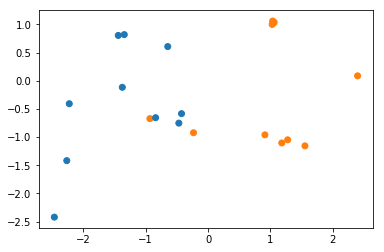

In [30]:
_ = plt.scatter(X[0,:], X[1,:], c=Y[1,:], cmap=ListedColormap(['#1f77b4', '#ff7f0e']))

Now we can construct a neural network we think might be able to classify these points.

In [31]:
model = Sequential([Linear(2, 10), ReLU(), 
                    Linear(10, 10), ReLU(), 
                    Linear(10, 2), SoftMax()], NLL())

Let's try training the model on the data for a few thousand iterations.

In [32]:
model.sgd(X, Y, 100000, 0.005)

Iteration = 1 	Acc = 0.7 	Loss = 0.3934914193303726
Iteration = 251 	Acc = 0.9 	Loss = 0.12411735563525321
Iteration = 501 	Acc = 0.95 	Loss = 0.44936215058337015
Iteration = 751 	Acc = 0.95 	Loss = 0.023703123508501126
Iteration = 1001 	Acc = 0.95 	Loss = 0.03389847921897066
Iteration = 1251 	Acc = 0.95 	Loss = 0.040771498401040975
Iteration = 1501 	Acc = 0.95 	Loss = 0.04041583067233898
Iteration = 1751 	Acc = 0.95 	Loss = 0.005750435344733054
Iteration = 2001 	Acc = 0.95 	Loss = 0.22655461864745374
Iteration = 2251 	Acc = 0.95 	Loss = 0.0010722377951524911
Iteration = 2501 	Acc = 0.95 	Loss = 0.05172183453643268
Iteration = 2751 	Acc = 0.95 	Loss = 0.022242247645096684
Iteration = 3001 	Acc = 0.95 	Loss = 0.03157322213905229
Iteration = 3251 	Acc = 0.95 	Loss = 0.07051094667061675
Iteration = 3501 	Acc = 0.95 	Loss = 0.37745435765886864
Iteration = 3751 	Acc = 0.95 	Loss = 1.878718234366643e-05
Iteration = 4001 	Acc = 0.95 	Loss = 0.0009934308898585354
Iteration = 4251 	Acc = 0.95 	

Iteration = 35001 	Acc = 0.95 	Loss = 2.5307850291916825e-09
Iteration = 35251 	Acc = 1.0 	Loss = 1.2328471577026046e-11
Iteration = 35501 	Acc = 0.95 	Loss = 5.046543867981812e-06
Iteration = 35751 	Acc = 0.95 	Loss = 1.4032338062493788e-06
Iteration = 36001 	Acc = 1.0 	Loss = 0.36628446991454305
Iteration = 36251 	Acc = 0.95 	Loss = 0.005117248166227754
Iteration = 36501 	Acc = 0.95 	Loss = 4.850334341761312e-06
Iteration = 36751 	Acc = 1.0 	Loss = 0.006711691691118829
Iteration = 37001 	Acc = 1.0 	Loss = 7.527402231332379e-07
Iteration = 37251 	Acc = 1.0 	Loss = 0.00164209628353335
Iteration = 37501 	Acc = 1.0 	Loss = 1.9573898058147855e-11
Iteration = 37751 	Acc = 1.0 	Loss = 1.884660651540642e-09
Iteration = 38001 	Acc = 1.0 	Loss = 0.6122466958115572
Iteration = 38251 	Acc = 0.95 	Loss = 0.00039516640914568805
Iteration = 38501 	Acc = 1.0 	Loss = 3.022500024070885e-07
Iteration = 38751 	Acc = 1.0 	Loss = 0.01229536755774261
Iteration = 39001 	Acc = 0.95 	Loss = 4.408331968695247e

Iteration = 70501 	Acc = 1.0 	Loss = -0.0
Iteration = 70751 	Acc = 1.0 	Loss = 2.0600188221940996e-12
Iteration = 71001 	Acc = 1.0 	Loss = 6.596426733285705e-06
Iteration = 71251 	Acc = 1.0 	Loss = 0.003733373890669672
Iteration = 71501 	Acc = 1.0 	Loss = 6.941447416887958e-12
Iteration = 71751 	Acc = 1.0 	Loss = 9.453379195028758e-10
Iteration = 72001 	Acc = 1.0 	Loss = 7.002609285257464e-06
Iteration = 72251 	Acc = 1.0 	Loss = 5.5079713164462104e-09
Iteration = 72501 	Acc = 1.0 	Loss = 0.0007428180872959329
Iteration = 72751 	Acc = 1.0 	Loss = 0.09587592815344274
Iteration = 73001 	Acc = 1.0 	Loss = 1.672461361176425e-08
Iteration = 73251 	Acc = 1.0 	Loss = 0.0006195831985393855
Iteration = 73501 	Acc = 1.0 	Loss = 0.05874640457468738
Iteration = 73751 	Acc = 1.0 	Loss = 1.0122488232229309e-08
Iteration = 74001 	Acc = 1.0 	Loss = -0.0
Iteration = 74251 	Acc = 1.0 	Loss = 4.663047725738992e-12
Iteration = 74501 	Acc = 1.0 	Loss = 1.1170146314789952e-08
Iteration = 74751 	Acc = 1.0 	Lo

Seems like it has fitted the data 100\%. Let's see what the decision boundary looks like.

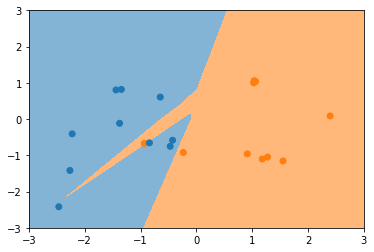

In [33]:
# Create a grid of points to classify
xx1, xx2 = np.meshgrid(np.arange(-3, 3, 0.005), np.arange(-3, 3, 0.005))

# Flatten the grid to pass into model
grid = np.c_[xx1.ravel(), xx2.ravel()].T

# Predict classification at every point on the grid
Z = model.forward(grid)[1,:].reshape(xx1.shape)

# Plot the prediction regions.
plt.imshow(Z, interpolation='bicubic', origin='lower', extent=[-3, 3, -3, 3], 
           cmap=ListedColormap(['#1f77b4', '#ff7f0e']), alpha=0.55, aspect='auto')

# Plot the original points.
_ = plt.scatter(X[0,:], X[1,:], c=Y[1,:], cmap=ListedColormap(['#1f77b4', '#ff7f0e']))